In [1]:
libraries <- c(
  "psych",
  "dplyr",
  "magrittr",
  "ggplot2",
  "gridExtra",
  "grid",
  "patchwork",
  "lmtest",
  "zoo",
  "xgboost",
  "Metrics",
  "plotly",
  "knitr",
  "forecast",
  "randomForest",
  "gbm",
  "lightgbm",
  "keras",
  "caret",
  "dplyr",
  "nortsTest",
  "tseries",
  "urca",
  "reshape2",
  "catboost"
  )

load_libraries <- function(libraries) {
  for (lib in libraries) {
    if (!require(lib, character.only = TRUE)) {
      install.packages(lib, dependencies = TRUE)
      library(lib, character.only = TRUE)
    }
  }
}

load_libraries(libraries)

data <- read.csv("/kaggle/input/bike-sharing-dataset/day.csv", header = TRUE)
data %<>% select(-c("instant", "casual", "registered"))
data$date <- as.Date(data$dteday, format = "%Y-%m-%d")
data$dteday <- NULL

Loading required package: psych

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: magrittr

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following objects are masked from ‘package:psych’:

    %+%, alpha


Loading required package: gridExtra


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: grid

Loading required package: patchwork

Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: xgboost


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice


Loading required package: Metrics

Lo

# INTRODUCTION

This notebook focuses on developing and evaluating SARIMAX and hybrid models to enhance forecasting performance. Before diving into this notebook, it is recommended to review the Exploratory Data Analysis (EDA) conducted in the previous notebook [here](https://www.kaggle.com/code/tarktunataalt/washington-dc-capital-bikeshare-eda) . The EDA provides essential insights into the data's patterns, trends, and seasonality.

In this notebook, we first develop a baseline SARIMAX model and then create hybrid models by integrating advanced machine learning techniques like XGBoost, CatBoost, LightGBM, GBM, and RandomForest. These hybrid models aim to leverage both the time-series capabilities of SARIMAX and the predictive power of these machine learning algorithms.

The next notebook will focus on STL (Seasonal-Trend Decomposition using LOESS) combined with hybrid models to further improve forecasting accuracy. Finally, the last notebook will concentrate on Long Short-Term Memory (LSTM) networks to capture complex temporal dependencies.

By following this structured approach, from EDA to advanced modeling techniques, we aim to build robust forecasting models for our data.

In [2]:
data <- data[order(data$date), ]

train_size <- floor(0.8 * nrow(data))
train_indices <- 1:train_size
test_indices <- (train_size + 1):nrow(data)

train_data <- data[train_indices, ]
test_data <- data[test_indices, ]

print(dim(train_data))
print(dim(test_data))

[1] 584  13
[1] 147  13


In [3]:
train_ts <- ts(train_data$cnt, start = c(2011, 1), frequency = 30)
test_ts <- ts(test_data$cnt, start = c(2011 + (train_size / 30), 1), frequency = 30)

# SARIMAX

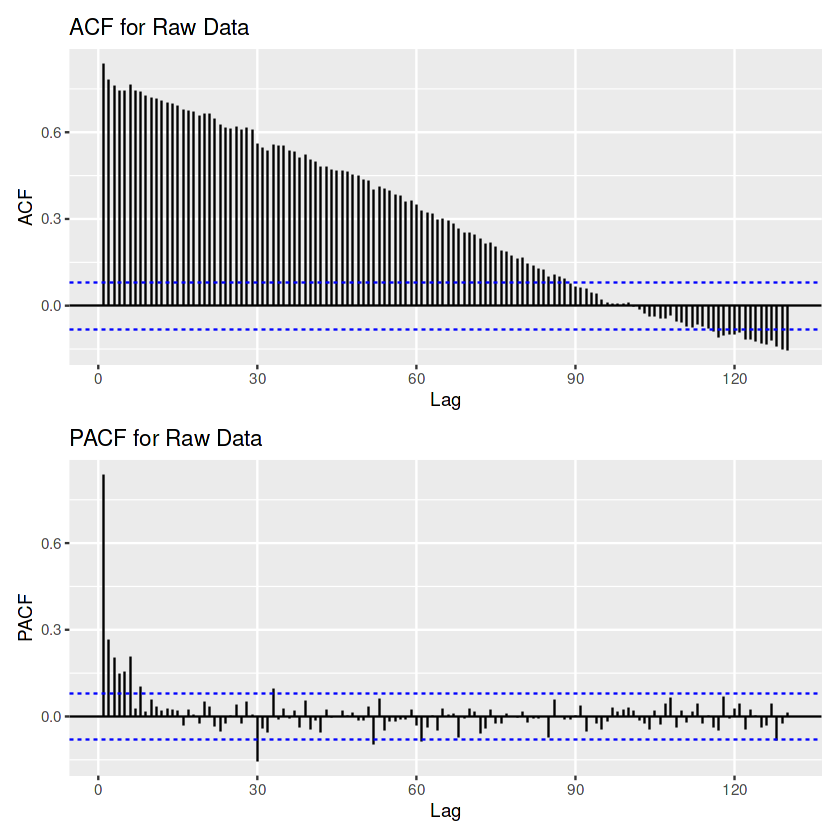

In [4]:
acf_plot <- ggAcf(train_ts, lag.max = 130) + ggtitle("ACF for Raw Data")
pacf_plot <- ggPacf(train_ts, lag.max = 130) + ggtitle("PACF for Raw Data")
acf_plot / pacf_plot

* **ACF (Autocorrelation Function)**:
The ACF plot shows significant autocorrelations at multiple lags, indicating that the raw data series is not stationary. The presence of spikes across all lags suggests a strong trend component in the data.

* **PACF (Partial Autocorrelation Function)**:
The PACF plot reveals significant partial autocorrelations at the initial lags, which then quickly drop off. This pattern implies that the series may have a trend and possibly seasonal components.

Given the consistent spikes at all lags in the ACF plot, it is clear that the raw data is non-stationary. To address this, we will apply a first-order non-seasonal differencing to remove the trend and achieve stationarity, which is essential for accurate time series modeling.

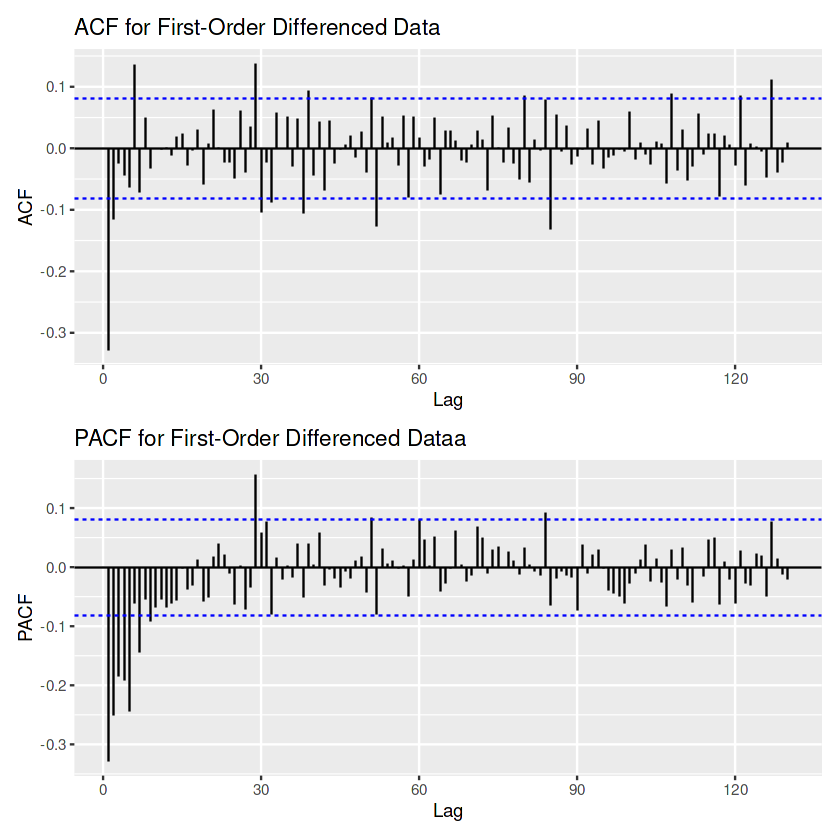

In [5]:
diff1 <- diff(train_ts, 1)
acf_plot <- ggAcf(diff1, lag.max = 130) + ggtitle("ACF for First-Order Differenced Data")
pacf_plot <- ggPacf(diff1, lag.max = 130) + ggtitle("PACF for First-Order Differenced Dataa")
acf_plot / pacf_plot

* **ACF (Autocorrelation Function)**:
The ACF plot shows significant cut-offs after a few lags, indicating that the non-seasonal part of the series can be modeled as MA(2).

* **PACF (Partial Autocorrelation Function)**:
The PACF plot shows a slight decline after the initial lags.

* **Seasonal Component**:
Both the ACF and PACF plots show a significant spike at the 30th lag. This suggests that for the seasonal component, AR(1), MA(1), and ARMA(1,1) models should be considered.

Before finalizing these decisions, stationarity tests need to be conducted for both the non-seasonal and seasonal components. These tests will be performed in the subsequent sections.

In [6]:
adf.test(diff1)

Warning message in adf.test(diff1):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  diff1
Dickey-Fuller = -12.859, Lag order = 8, p-value = 0.01
alternative hypothesis: stationary


The Augmented Dickey-Fuller test was performed on the first-order differenced data. The test statistic is -12.859 with a p-value of 0.01. Since the p-value is less than 0.05, we reject the null hypothesis that the data has a unit root, indicating that the data is stationary. Consequently, the result supports that the data is stationary.

In [7]:
summary(ur.kpss(diff1, type = "tau"))


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: tau with 6 lags. 

Value of test-statistic is: 0.0164 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.119 0.146  0.176 0.216



The KPSS Unit Root Test was performed on the first-order differenced data. The test statistic is 0.0164.

Since the test statistic (0.0164) is less than the critical value at the 1% significance level (0.216), we fail to reject the null hypothesis that the data is stationary. Consequently, the result supports that the data is stationary.

In [8]:
seasonal.test(diff1, seasonal = c("ocsb","ch","hegy"), alpha = 0.05)


	OCSB test

data:  y

Test statistic: -17.2611, 5% critical value: -1.7436
alternative hypothesis: stationary

Lag order 2 was selected using AIC


The OCSB test was performed on the seasonal component of the data. The test statistic is -17.2611, with a 5% critical value of -1.7436.

Since the test statistic (-17.2611) is less than the 5% critical value (-1.7436), we reject the null hypothesis that the seasonal component has a unit root, indicating that the seasonal component is stationary. Consequently, the result supports that the seasonal component of the data is stationary.

In [9]:
exog <- train_data[, !names(train_data) %in% c("cnt", "date")]
exog$season <- as.numeric(exog$season)
exog$yr <- as.numeric(exog$yr)
exog$mnth <- as.numeric(exog$mnth)
exog$holiday <- as.numeric(exog$holiday)
exog$weekday <- as.numeric(exog$weekday)
exog$workingday <- as.numeric(exog$workingday)
exog$weathersit <- as.numeric(exog$weathersit)
exog_matrix <- as.matrix(exog)

In [10]:
sarimax_model1 <- Arima(train_ts, order = c(0, 1, 2), seasonal = list(order = c(1, 0, 0), period = 30), xreg = exog_matrix)
sarimax_model2 <- Arima(train_ts, order = c(0, 1, 2), seasonal = list(order = c(0, 0, 1), period = 30), xreg = exog_matrix)
sarimax_model3 <- Arima(train_ts, order = c(0, 1, 2), seasonal = list(order = c(1, 0, 1), period = 30), xreg = exog_matrix)

In [11]:
coeftest(sarimax_model1)
coeftest(sarimax_model2)
coeftest(sarimax_model3)



z test of coefficients:

              Estimate  Std. Error  z value  Pr(>|z|)    
ma1        -6.4491e-01  3.9308e-02 -16.4069 < 2.2e-16 ***
ma2        -1.8136e-01  3.8270e-02  -4.7389 2.149e-06 ***
sar1       -6.9055e-02  4.2895e-02  -1.6098  0.107432    
season      2.3699e+02  1.0935e+02   2.1673  0.030209 *  
yr          2.1726e+03  1.0608e+03   2.0480  0.040557 *  
mnth        1.1752e+02  9.0540e+01   1.2980  0.194276    
holiday    -1.9943e+02  1.6184e+02  -1.2323  0.217847    
weekday     4.2118e+01  1.3615e+01   3.0934  0.001979 ** 
workingday  7.3388e+01  6.3158e+01   1.1620  0.245247    
weathersit -5.0316e+02  6.4278e+01  -7.8278 4.966e-15 ***
temp        1.9262e+03  2.2440e+03   0.8584  0.390673    
atemp       2.2213e+03  2.3881e+03   0.9302  0.352281    
hum        -1.5751e+03  2.7543e+02  -5.7188 1.073e-08 ***
windspeed  -2.3466e+03  4.0925e+02  -5.7340 9.811e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



z test of coefficients:

              Estimate  Std. Error  z value  Pr(>|z|)    
ma1        -6.4503e-01  3.9294e-02 -16.4155 < 2.2e-16 ***
ma2        -1.8126e-01  3.8264e-02  -4.7370 2.169e-06 ***
sma1       -7.0018e-02  4.3269e-02  -1.6182  0.105624    
season      2.3667e+02  1.0934e+02   2.1645  0.030429 *  
yr          2.1844e+03  1.0567e+03   2.0672  0.038717 *  
mnth        1.1829e+02  9.0207e+01   1.3114  0.189736    
holiday    -2.0078e+02  1.6185e+02  -1.2405  0.214783    
weekday     4.2124e+01  1.3640e+01   3.0883  0.002013 ** 
workingday  7.3419e+01  6.3248e+01   1.1608  0.245723    
weathersit -5.0270e+02  6.4274e+01  -7.8212 5.234e-15 ***
temp        1.9055e+03  2.2451e+03   0.8487  0.396032    
atemp       2.2441e+03  2.3897e+03   0.9391  0.347679    
hum        -1.5805e+03  2.7538e+02  -5.7395 9.494e-09 ***
windspeed  -2.3434e+03  4.0961e+02  -5.7209 1.059e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



z test of coefficients:

              Estimate  Std. Error  z value  Pr(>|z|)    
ma1        -6.4617e-01  3.9292e-02 -16.4455 < 2.2e-16 ***
ma2        -1.7986e-01  3.8333e-02  -4.6920 2.706e-06 ***
sar1        5.0607e-01  6.3841e-01   0.7927   0.42795    
sma1       -5.7157e-01  6.1695e-01  -0.9264   0.35422    
season      2.3072e+02  1.1045e+02   2.0889   0.03671 *  
yr          2.2954e+03  1.0202e+03   2.2500   0.02445 *  
mnth        1.2644e+02  8.7401e+01   1.4466   0.14800    
holiday    -1.9370e+02  1.6237e+02  -1.1930   0.23289    
weekday     4.2396e+01  1.3784e+01   3.0757   0.00210 ** 
workingday  7.6373e+01  6.3513e+01   1.2025   0.22918    
weathersit -5.0489e+02  6.4404e+01  -7.8394 4.527e-15 ***
temp        1.6843e+03  2.2605e+03   0.7451   0.45620    
atemp       2.4599e+03  2.4054e+03   1.0227   0.30647    
hum        -1.6057e+03  2.7732e+02  -5.7900 7.037e-09 ***
windspeed  -2.2964e+03  4.1233e+02  -5.5693 2.557e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*

The coefficients for these models were tested for statistical significance. The results showed that the seasonal components in all three models were not statistically significant. This implies that the seasonal part of the models did not contribute significantly to the model's performance.

Given that the seasonal components are not significant, we will introduce a seasonal differencing term to account for potential seasonality in the data. Additionally, all non-significant parameters will be dropped to refine the model. This process will help in simplifying the model and improving its interpretability while maintaining its predictive performance.

In [12]:
exog %<>% select(c("season","yr","weekday", "weathersit", "hum", "windspeed"))
exog_matrix <- as.matrix(exog)

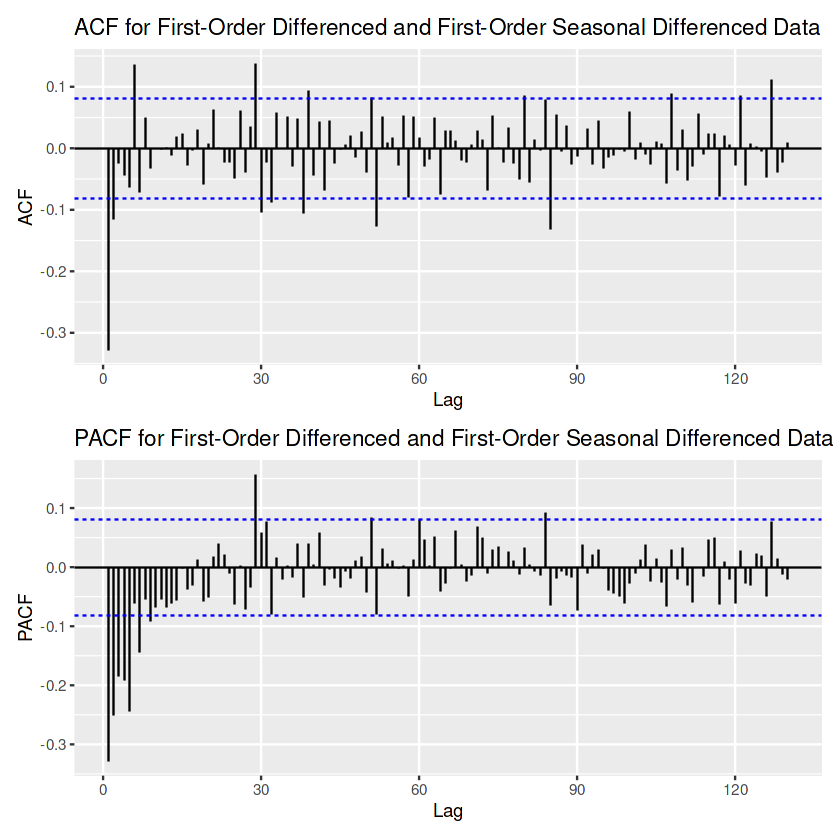

In [13]:
diff130 <- diff(diff1, 30)
acf_plot <- ggAcf(diff1, lag.max = 130) + ggtitle("ACF for First-Order Differenced and First-Order Seasonal Differenced Data")
pacf_plot <- ggPacf(diff1, lag.max = 130) + ggtitle("PACF for First-Order Differenced and First-Order Seasonal Differenced Data")
acf_plot / pacf_plot

* **ACF (Autocorrelation Function)**:
The ACF plot for the first-order differenced and first-order seasonal differenced data shows significant cut-offs after a few lags, indicating that the non-seasonal part of the series can be modeled as MA(2).

* **PACF (Partial Autocorrelation Function)**:
The PACF plot for the same data reveals a slight decline after the initial lags.


For the seasonal differenced data, the same observation holds: both the ACF and PACF plots show a significant spike at the 30th lag. This suggests that for the seasonal component, AR(1), MA(1), and ARMA(1,1) models should be considered.

Thus, we can apply similar modeling strategies for both the non-seasonal and seasonal components, considering AR(1), MA(1), and ARMA(1,1) models for the seasonal part of the differenced data.

In [14]:
sarimax_model1 <- Arima(train_ts, order = c(0, 1, 2), seasonal = list(order = c(1, 1, 0), period = 30), xreg = exog_matrix)
sarimax_model2 <- Arima(train_ts, order = c(0, 1, 2), seasonal = list(order = c(0, 1, 1), period = 30), xreg = exog_matrix)
sarimax_model3 <- Arima(train_ts, order = c(0, 1, 2), seasonal = list(order = c(1, 1, 1), period = 30), xreg = exog_matrix)

In [15]:
coeftest(sarimax_model1)
coeftest(sarimax_model2)
coeftest(sarimax_model3)


z test of coefficients:

              Estimate  Std. Error  z value  Pr(>|z|)    
ma1        -6.5643e-01  4.1128e-02 -15.9606 < 2.2e-16 ***
ma2        -1.7989e-01  3.9244e-02  -4.5841 4.560e-06 ***
sar1       -5.1615e-01  3.6314e-02 -14.2134 < 2.2e-16 ***
season      2.3860e+02  1.1648e+02   2.0484  0.040521 *  
yr          2.6601e+02  4.3586e+02   0.6103  0.541662    
weekday     4.3166e+01  1.3131e+01   3.2872  0.001012 ** 
weathersit -6.2558e+02  7.1421e+01  -8.7591 < 2.2e-16 ***
hum        -7.1030e+02  3.0686e+02  -2.3148  0.020625 *  
windspeed  -2.6500e+03  4.3550e+02  -6.0850 1.165e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



z test of coefficients:

              Estimate  Std. Error  z value  Pr(>|z|)    
ma1        -6.4999e-01  4.1395e-02 -15.7022 < 2.2e-16 ***
ma2        -1.7075e-01  3.9518e-02  -4.3208 1.555e-05 ***
sma1       -9.9988e-01  2.1957e-01  -4.5539 5.266e-06 ***
season      2.5953e+02  1.2108e+02   2.1434 0.0320786 *  
yr          5.1118e+02  4.5996e+02   1.1114 0.2664159    
weekday     4.3108e+01  1.4571e+01   2.9584 0.0030923 ** 
weathersit -5.8110e+02  7.1498e+01  -8.1275 4.382e-16 ***
hum        -1.0227e+03  3.0937e+02  -3.3056 0.0009476 ***
windspeed  -2.3684e+03  4.3959e+02  -5.3878 7.133e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



z test of coefficients:

              Estimate  Std. Error  z value  Pr(>|z|)    
ma1        -6.4744e-01  4.1486e-02 -15.6063 < 2.2e-16 ***
ma2        -1.7261e-01  3.9515e-02  -4.3683 1.252e-05 ***
sar1       -4.2447e-02  5.0908e-02  -0.8338 0.4044023    
sma1       -9.4937e-01  7.8237e-02 -12.1346 < 2.2e-16 ***
season      2.6325e+02  1.2094e+02   2.1766 0.0295068 *  
yr          5.0742e+02  4.6014e+02   1.1027 0.2701363    
weekday     4.2417e+01  1.4623e+01   2.9007 0.0037233 ** 
weathersit -5.7513e+02  7.1820e+01  -8.0080 1.166e-15 ***
hum        -1.0256e+03  3.0909e+02  -3.3180 0.0009067 ***
windspeed  -2.3505e+03  4.3982e+02  -5.3443 9.078e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


The coefficients for these models were tested for statistical significance. The results indicated the following:

In Model 3 (SARIMA(0,1,2)(1,1,1)[30]), the sar1 parameter was not statistically significant (p-value = 0.404), indicating that the seasonal autoregressive term does not contribute significantly to the model. Therefore, this parameter will not be considered further.
In all models, the year variable (yr) was not statistically significant (p-values > 0.05), suggesting that this variable does not have a significant impact on the model and will be dropped.
Based on these findings, we will refine and re-evaluate the first two models by excluding the year variable and any other non-significant parameters:

Refined Model 1: SARIMA(0,1,2)(1,1,0)[30] without year
Refined Model 2: SARIMA(0,1,2)(0,1,1)[30] without year
These refined models will be further analyzed to ensure improved performance and interpretability.

In [16]:
exog %<>% select(c("season","weekday", "weathersit", "hum", "windspeed"))
exog_matrix <- as.matrix(exog)

In [17]:
automodel <- auto.arima(train_ts, stepwise = TRUE, trace = TRUE, seasonal = TRUE, approximation = FALSE, allowdrift = TRUE, allowmean = TRUE, xreg = exog_matrix)
sarimax_model1 <- Arima(train_ts, order = c(0, 1, 2), seasonal = list(order = c(1, 1, 0), period = 30), xreg = exog_matrix)
sarimax_model2 <- Arima(train_ts, order = c(0, 1, 2), seasonal = list(order = c(0, 1, 1), period = 30), xreg = exog_matrix)


 Regression with ARIMA(2,1,2)(1,0,1)[30] errors : Inf
 Regression with ARIMA(0,1,0)            errors : 9518.951
 Regression with ARIMA(1,1,0)(1,0,0)[30] errors : 9440.043
 Regression with ARIMA(0,1,1)(0,0,1)[30] errors : 9357.512
 Regression with ARIMA(0,1,0)            errors : 9516.984
 Regression with ARIMA(0,1,1)            errors : 9356.016
 Regression with ARIMA(0,1,1)(1,0,0)[30] errors : 9357.543
 Regression with ARIMA(0,1,1)(1,0,1)[30] errors : 9358.757
 Regression with ARIMA(1,1,1)            errors : 9333.14
 Regression with ARIMA(1,1,1)(1,0,0)[30] errors : 9333.77
 Regression with ARIMA(1,1,1)(0,0,1)[30] errors : 9333.74
 Regression with ARIMA(1,1,1)(1,0,1)[30] errors : Inf
 Regression with ARIMA(1,1,0)            errors : 9439.742
 Regression with ARIMA(2,1,1)            errors : 9335.132
 Regression with ARIMA(1,1,2)            errors : 9335.159
 Regression with ARIMA(0,1,2)            errors : 9335.871
 Regression with ARIMA(2,1,0)            errors : 9414.791
 Regressi

To avoid performance loss, all variables in the exogenous matrix were made significant before selecting the best model using the auto.arima function. The best model suggested by auto.arima was Regression with ARIMA(1,1,1) errors.

However, while auto.arima provided a non-seasonal ARIMA model recommendation, seasonality can still be captured through the seasonal variable in the exogenous matrix. This means that although auto.arima did not explicitly identify a seasonal component, the presence of the seasonal variable allows the model to account for any underlying seasonal patterns in the data.

Other identified SARIMAX models will also be evaluated to ensure comprehensive model performance assessment.

In [18]:
coeftest(automodel)
coeftest(sarimax_model1)
coeftest(sarimax_model2)


z test of coefficients:

              Estimate  Std. Error  z value  Pr(>|z|)    
ar1         2.5797e-01  5.0168e-02   5.1420 2.718e-07 ***
ma1        -8.6906e-01  2.3828e-02 -36.4720 < 2.2e-16 ***
drift       8.9844e+00  5.2825e+00   1.7008  0.088983 .  
season      2.1104e+02  1.2067e+02   1.7489  0.080309 .  
weekday     4.1726e+01  1.4350e+01   2.9077  0.003641 ** 
weathersit -5.7379e+02  6.7782e+01  -8.4652 < 2.2e-16 ***
hum        -1.1979e+03  2.9185e+02  -4.1045 4.052e-05 ***
windspeed  -2.2379e+03  4.1421e+02  -5.4027 6.566e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



z test of coefficients:

              Estimate  Std. Error  z value  Pr(>|z|)    
ma1        -6.5402e-01  4.0960e-02 -15.9673 < 2.2e-16 ***
ma2        -1.7991e-01  3.9242e-02  -4.5845 4.551e-06 ***
sar1       -5.1681e-01  3.6273e-02 -14.2479 < 2.2e-16 ***
season      2.2845e+02  1.1601e+02   1.9693  0.048923 *  
weekday     4.2594e+01  1.3093e+01   3.2531  0.001141 ** 
weathersit -6.2334e+02  7.1296e+01  -8.7429 < 2.2e-16 ***
hum        -7.2381e+02  3.0588e+02  -2.3663  0.017968 *  
windspeed  -2.6383e+03  4.3493e+02  -6.0661 1.311e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



z test of coefficients:

              Estimate  Std. Error  z value  Pr(>|z|)    
ma1        -6.4651e-01  4.1237e-02 -15.6779 < 2.2e-16 ***
ma2        -1.7001e-01  3.9517e-02  -4.3021 1.692e-05 ***
sma1       -9.9292e-01  2.5619e-01  -3.8757 0.0001063 ***
season      2.4011e+02  1.2087e+02   1.9866 0.0469711 *  
weekday     4.2146e+01  1.4539e+01   2.8989 0.0037449 ** 
weathersit -5.7706e+02  7.1409e+01  -8.0810 6.425e-16 ***
hum        -1.0498e+03  3.0856e+02  -3.4023 0.0006683 ***
windspeed  -2.3574e+03  4.3930e+02  -5.3663 8.036e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


* **Auto.ARIMA Model: Regression with ARIMA(1,1,1)**
The auto.arima function suggested a non-seasonal ARIMA model. In this model, the ar1 and ma1 terms are highly significant, indicating a strong autoregressive and moving average component. The drift term is marginally significant, while the season term is near the significance threshold (p-value = 0.080), suggesting that the model might be able to capture seasonality to some extent through the exogenous season variable.

* **SARIMA(0,1,2)(1,1,0)[30]**
The ma1, ma2, and sar1 terms are highly significant, indicating a strong moving average and seasonal autoregressive component. The season variable is significant at the 5% level, suggesting that this model captures the seasonality better than the auto.arima model. Other significant variables include weekday, weathersit, hum, and windspeed.

* **SARIMA(0,1,2)(0,1,1)[30]**

The ma1, ma2, and sma1 terms are highly significant, indicating a strong moving average and seasonal moving average component. The season variable is significant at the 5% level, similar to the previous SARIMA model. This suggests that this model also captures seasonality effectively. Other significant variables include weekday, weathersit, hum, and windspeed.

* **Summary**
The auto.arima function did not suggest a seasonal model, and while the season variable in this model was near the significance threshold, it was not definitively significant. In contrast, the SARIMA models with seasonal components showed that the season variable was significant, indicating that these models can capture seasonality more effectively. Based on these results, it is clear that incorporating seasonal differencing and seasonal components into the SARIMA models provides a better fit for the data. Therefore, the refined SARIMA models will be further evaluated and compared to ensure optimal model performance.


	Ljung-Box test

data:  Residuals from Regression with ARIMA(0,1,2)(1,1,0)[30] errors
Q* = 176.48, df = 57, p-value = 3.83e-14

Model df: 3.   Total lags used: 60



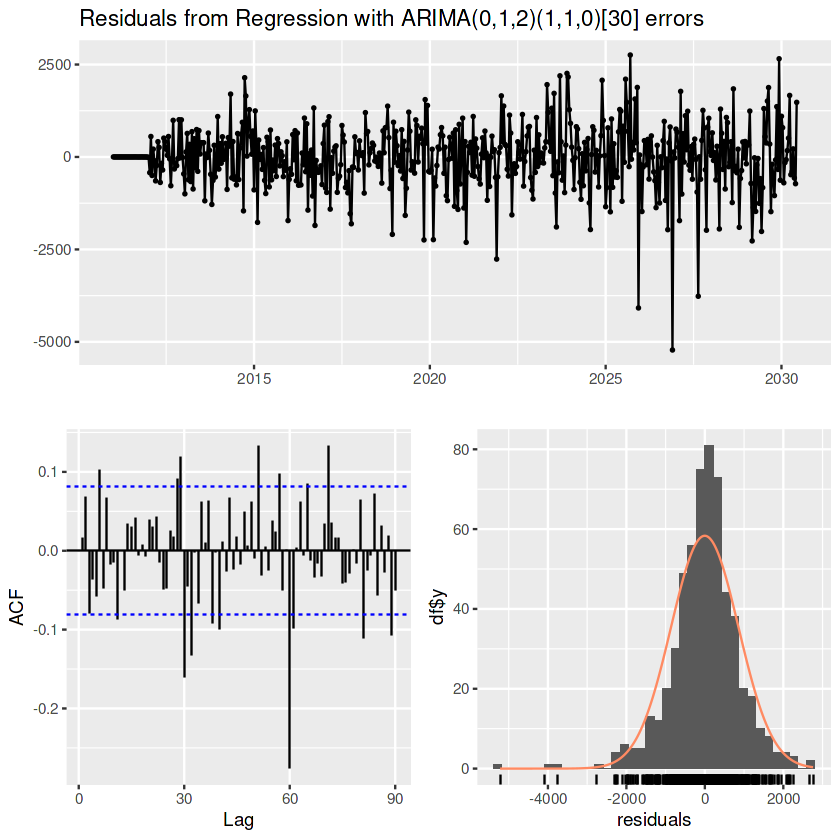

In [19]:
checkresiduals(sarimax_model1)

* Residuals are randomly distributed around zero, indicating a good fit overall, though some large residuals suggest potential outliers.
* Most autocorrelations are within significance bounds, indicating that residuals are mostly white noise, with a few exceptions.
* Residuals are approximately normally distributed, supporting the model's assumptions, with a symmetric spread around zero.

Overall, the model fits well, capturing the main data patterns and leaving mostly white noise residuals.

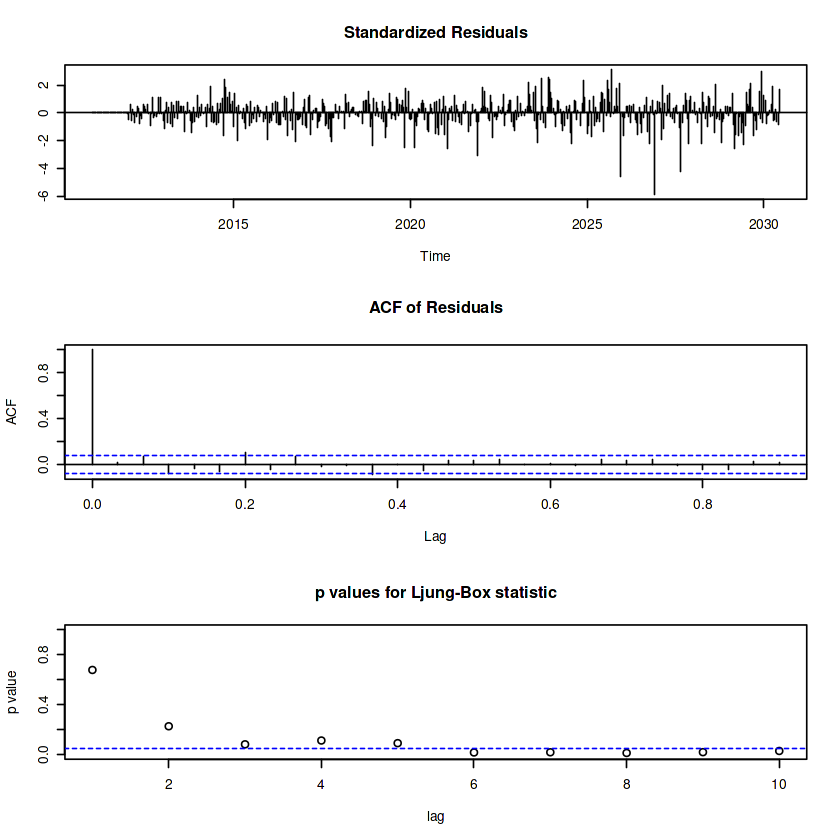

In [20]:
tsdiag(sarimax_model1)

* The standardized residuals are mostly within the range of -2 to 2, indicating that the residuals are generally well-behaved and there are no obvious patterns or large outliers.
* The ACF plot of the residuals shows that most autocorrelations are within the significance bounds, suggesting that the residuals behave like white noise. This indicates that the model has effectively captured the structure in the data.
* The p-values for the Ljung-Box test at various lags are not sufficiently high, indicating that there might still be some autocorrelation remaining in the residuals. This suggests that while the model fits reasonably well, there may be room for improvement. Consequently, exploring alternative models may be necessary to better address these remaining autocorrelations.

Overall, the residual analysis suggests that the model fits the data well, but the p-values indicate that there might still be some remaining autocorrelation that could be addressed. Therefore, considering alternative models may help in improving the model's performance further.

In [21]:
Box.test(sarimax_model1$residuals,lag=7)
Box.test(sarimax_model1$residuals,lag=15)
Box.test(sarimax_model1$residuals,lag=30)
Box.test(sarimax_model1$residuals,lag=60)
Box.test(sarimax_model1$residuals,lag=90)


	Box-Pierce test

data:  sarimax_model1$residuals
X-squared = 17.06, df = 7, p-value = 0.01701



	Box-Pierce test

data:  sarimax_model1$residuals
X-squared = 27.196, df = 15, p-value = 0.02718



	Box-Pierce test

data:  sarimax_model1$residuals
X-squared = 62.725, df = 30, p-value = 0.0004254



	Box-Pierce test

data:  sarimax_model1$residuals
X-squared = 164.13, df = 60, p-value = 1.284e-11



	Box-Pierce test

data:  sarimax_model1$residuals
X-squared = 217.18, df = 90, p-value = 1.625e-12


The p-values significantly decrease at lags that are multiples of 30, approaching 0, indicating the presence of strong seasonal autocorrelation at these lags. This suggests that the current SARIMAX model may not fully capture the seasonal patterns in the data. Consequently, there is a need to explore alternative models or further refine the current model to better address these seasonal autocorrelations.

In [22]:
shapiro.test(sarimax_model1$residuals)


	Shapiro-Wilk normality test

data:  sarimax_model1$residuals
W = 0.95875, p-value = 1.002e-11


The Shapiro-Wilk test results indicate that the residuals do not follow a normal distribution. This suggests that the model may not be adequately capturing all the underlying patterns in the data. The lack of normality in the residuals points to potential issues in model specification. Consequently, it may be necessary to explore alternative models to better fit the data and address these normality issues.


	Ljung-Box test

data:  Residuals from Regression with ARIMA(0,1,2)(0,1,1)[30] errors
Q* = 74.883, df = 57, p-value = 0.05624

Model df: 3.   Total lags used: 60



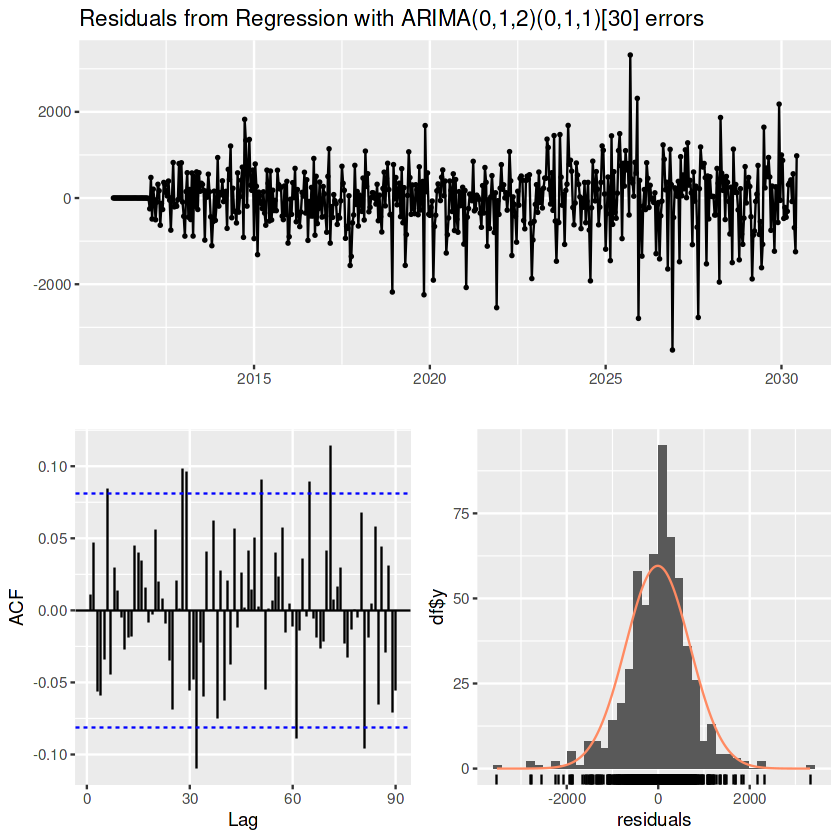

In [23]:
checkresiduals(sarimax_model2)

* The residuals are randomly distributed around zero, indicating a generally good fit. However, some larger residuals suggest periods of higher variability or potential outliers.
* The ACF plot shows that most autocorrelations are within the significance bounds, indicating that the residuals are mostly white noise. This suggests that the model has effectively captured the main patterns in the data.
* The histogram of residuals, with an overlaid normal distribution curve, indicates that the residuals are approximately normally distributed. However, some deviations from normality are present, particularly in the tails.

Overall, the residual analysis suggests that the Regression with ARIMA(0,1,2)(0,1,1)[30] errors model fits the data well, capturing the main patterns and leaving mostly white noise residuals. However, the presence of larger residuals and deviations from normality indicate that exploring alternative models may help to better address these issues.

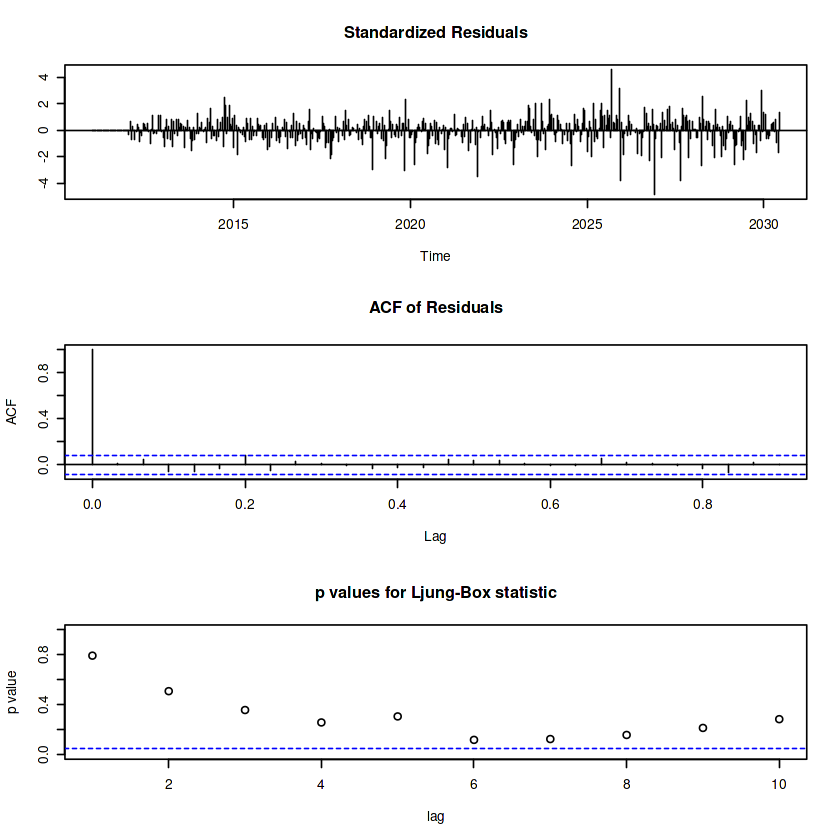

In [24]:
tsdiag(sarimax_model2)

* The standardized residuals are mostly within the range of -2 to 2, indicating that the residuals are generally well-behaved with no obvious patterns or large outliers.
* The ACF plot of the residuals shows that most autocorrelations are within the significance bounds, suggesting that the residuals behave like white noise. This indicates that the model has effectively captured the structure in the data.
* The p-values for the Ljung-Box test at various lags occasionally decrease but remain well above the threshold value. This indicates that, despite some fluctuations, there is no significant autocorrelation remaining in the residuals.

Overall, the residual analysis suggests that the model fits the data well, capturing the main patterns and leaving mostly white noise residuals. Although the p-values for the Ljung-Box test fluctuate, they consistently remain above the significance threshold, indicating that significant autocorrelation is not present.

In [25]:
Box.test(sarimax_model2$residuals,lag=7)
Box.test(sarimax_model2$residuals,lag=15)
Box.test(sarimax_model2$residuals,lag=30)
Box.test(sarimax_model2$residuals,lag=60)
Box.test(sarimax_model2$residuals,lag=90)


	Box-Pierce test

data:  sarimax_model2$residuals
X-squared = 11.267, df = 7, p-value = 0.1274



	Box-Pierce test

data:  sarimax_model2$residuals
X-squared = 14.856, df = 15, p-value = 0.4618



	Box-Pierce test

data:  sarimax_model2$residuals
X-squared = 34.544, df = 30, p-value = 0.2596



	Box-Pierce test

data:  sarimax_model2$residuals
X-squared = 70.728, df = 60, p-value = 0.162



	Box-Pierce test

data:  sarimax_model2$residuals
X-squared = 111.91, df = 90, p-value = 0.0587


The p-values for the Box-Pierce test at all lags remain above the threshold value, indicating that there is no significant autocorrelation remaining in the residuals at these lags. This suggests that the SARIMAX(0,1,2)(0,1,1)[30] model effectively captures the autocorrelation structure of the data. Although the p-values fluctuate, they consistently stay above the significance threshold, supporting the adequacy of the model in handling autocorrelation.

In [26]:
shapiro.test(sarimax_model2$residuals)


	Shapiro-Wilk normality test

data:  sarimax_model2$residuals
W = 0.95838, p-value = 8.632e-12


The Shapiro-Wilk test results indicate that the residuals are far from the threshold for normal distribution, suggesting that the residuals do not follow a normal distribution. Despite this, the SARIMAX(0,1,2)(0,1,1)[30] model provides the best overall validity compared to other models evaluated. It effectively captures the autocorrelation structure of the data, as indicated by the Box-Pierce test results, and manages to handle the data patterns adequately despite the residuals not being perfectly normally distributed. Thus, this model is considered the most valid among the tested models.

In [27]:
exog_matrix_train <- data.matrix(train_data[, c("season", "weekday", "weathersit", "hum", "windspeed")])
exog_matrix_test <- data.matrix(test_data[, c("season", "weekday", "weathersit", "hum", "windspeed")])

sarimax_forecast <- forecast(sarimax_model2, xreg = exog_matrix_test, h = nrow(test_data))

sarimax_pred <- sarimax_forecast$mean
actual_values <- test_data$cnt

residuals_train <- residuals(sarimax_model2)
residuals_test <- actual_values - sarimax_pred


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


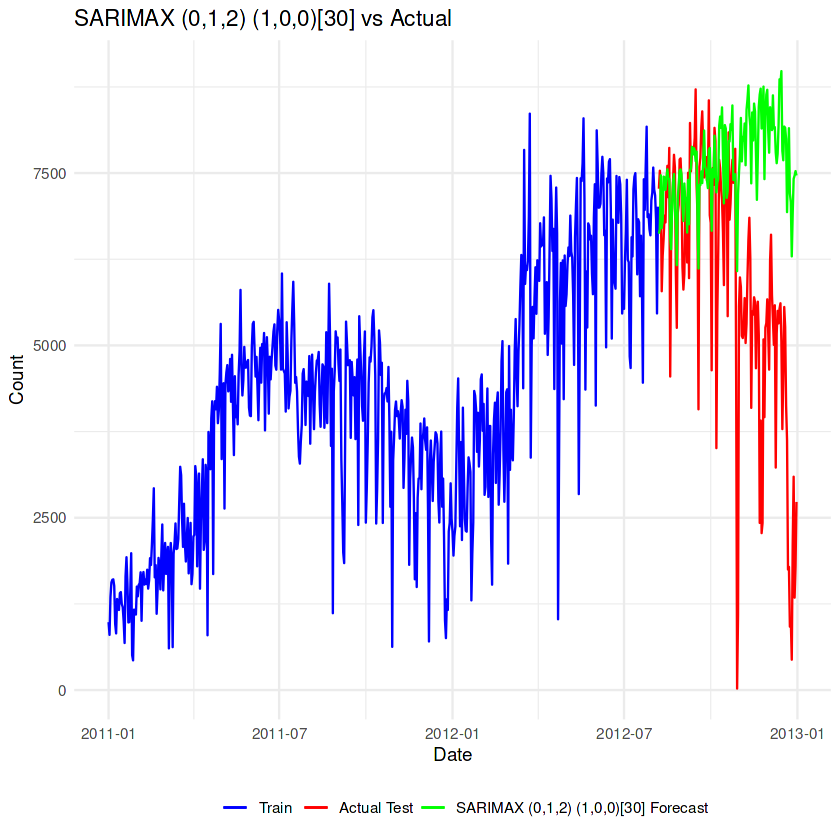

In [28]:
train_df <- data.frame(date = train_data$date, cnt = train_data$cnt, type = "Train")
test_df <- data.frame(date = test_data$date, cnt = test_data$cnt, type = "Test")
sarimax_forecast_df <- data.frame(date = test_data$date, cnt = sarimax_pred, type = "SARIMAX Forecast")

ggplot() +
  geom_line(data = train_df, aes(x = date, y = cnt, color = 'Train'), size = 0.5) +
  geom_line(data = test_df, aes(x = date, y = cnt, color = 'Actual Test'), size = 0.5) +
  geom_line(data = sarimax_forecast_df, aes(x = date, y = cnt, color = 'SARIMAX (0,1,2) (1,0,0)[30] Forecast'), size = 0.5,) +
  labs(title = 'SARIMAX (0,1,2) (1,0,0)[30] vs Actual',
       x = 'Date',
       y = 'Count') +
scale_color_manual(values = c('Train' = 'blue', 'Actual Test' = 'red', 'SARIMAX (0,1,2) (1,0,0)[30] Forecast' = 'green'),
                     breaks = c('Train', 'Actual Test', 'SARIMAX (0,1,2) (1,0,0)[30] Forecast')) +  theme_minimal() +
  theme(legend.position = "bottom")+
  guides(color = guide_legend(title = NULL))

The green line representing the SARIMAX model's forecast initially follows the actual test data (red line) quite closely. This indicates that the SARIMAX model captures the fundamental patterns in the data well at the start. However, the model struggles to predict the subsequent downward trend, leading to deviations in its forecasts.

Overall, the plot shows that the SARIMAX(0,1,2)(1,0,0)[30] model makes reasonable predictions initially but fails to anticipate the reverse trend accurately. This suggests that while the model captures some of the seasonal and trend components in the data, it may require further refinement to improve its predictive performance for unexpected changes.

The aim is to enhance the forecasting performance of the SARIMAX model by testing various hybrid models. These hybrid models will combine the residuals from the SARIMAX model with different machine learning techniques, including XGBoost, CatBoost, LightGBM, GBM, and RandomForest. The goal is to apply these advanced regression algorithms to the residuals left by the SARIMAX model, thereby capturing any remaining patterns or nonlinearities that the initial model might have missed. Each machine learning algorithm brings its unique strengths: XGBoost's robustness and scalability, CatBoost's ability to handle categorical features, LightGBM's speed and efficiency, GBM's simplicity, and RandomForest's capacity to deal with overfitting. By combining the time-series capabilities of SARIMAX with the powerful predictive performance of these machine learning models, the aim is to achieve more accurate and reliable forecasts.

# SARIMAX AND HYBRID MODELS

In [29]:
sarimax_rmse <- rmse(actual_values, sarimax_pred)

# XGBoost
dtrain <- xgb.DMatrix(data = exog_matrix_train, label = residuals_train)
dtest <- xgb.DMatrix(data = exog_matrix_test)



xgboost_model <- xgboost(data = dtrain, nrounds = 100, objective = "reg:squarederror", verbose = 0)
xgboost_residuals <- predict(xgboost_model, dtest)
xgboost_pred <- sarimax_pred + xgboost_residuals
xgboost_rmse <- rmse(actual_values, xgboost_pred)

# CatBoost
catboost_pool_train <- catboost.load_pool(data = exog_matrix_train, label = residuals_train)
catboost_pool_test <- catboost.load_pool(data = exog_matrix_test)

catboost_model <- catboost.train(catboost_pool_train, params = list(iterations = 100, loss_function = 'RMSE', verbose = 0))
catboost_residuals <- catboost.predict(catboost_model, catboost_pool_test)
catboost_pred <- sarimax_pred + catboost_residuals
catboost_rmse <- rmse(actual_values, catboost_pred)

# LightGBM
lightgbm_train <- lgb.Dataset(data = exog_matrix_train, label = residuals_train)
lightgbm_params <- list(objective = "regression", metric = "rmse")

lightgbm_model <- lgb.train(params = lightgbm_params, data = lightgbm_train, nrounds = 100, verbose = 0)
lightgbm_residuals <- predict(lightgbm_model, exog_matrix_test)
lightgbm_pred <- sarimax_pred + lightgbm_residuals
lightgbm_rmse <- rmse(actual_values, lightgbm_pred)

# GBM
gbm_model <- gbm(residuals_train ~ ., data = as.data.frame(exog_matrix_train), distribution = "gaussian", n.trees = 100, interaction.depth = 3, shrinkage = 0.1, verbose = FALSE)
gbm_residuals <- predict(gbm_model, as.data.frame(exog_matrix_test), n.trees = 100)
gbm_pred <- sarimax_pred + gbm_residuals
gbm_rmse <- rmse(actual_values, gbm_pred)

# RandomForest
rf_model <- randomForest(residuals_train ~ ., data = as.data.frame(exog_matrix_train), ntree = 100)
rf_residuals <- predict(rf_model, as.data.frame(exog_matrix_test))
rf_pred <- sarimax_pred + rf_residuals
rf_rmse <- rmse(actual_values, rf_pred)


In [30]:
rmse_values <- data.frame(
  Model = c("SARIMAX", "SARIMAX + XGBoost", "SARIMAX + CatBoost", "SARIMAX + LightGBM", "SARIMAX + GBM", "SARIMAX + RandomForest"),
  RMSE = c(sarimax_rmse, xgboost_rmse, catboost_rmse, lightgbm_rmse, gbm_rmse, rf_rmse)
)

kable(rmse_values, format = "markdown", col.names = c("Model", "RMSE"))




|Model                  |     RMSE|
|:----------------------|--------:|
|SARIMAX                | 2599.479|
|SARIMAX + XGBoost      | 2539.241|
|SARIMAX + CatBoost     | 2588.540|
|SARIMAX + LightGBM     | 2577.548|
|SARIMAX + GBM          | 2558.141|
|SARIMAX + RandomForest | 2563.741|

The table presents the RMSE values for the baseline SARIMAX model and its hybrid versions with various machine learning techniques. The SARIMAX + XGBoost hybrid model achieves the lowest RMSE (2539.241), indicating that XGBoost effectively captures additional patterns in the residuals, thereby improving forecast accuracy. Other hybrid models, such as SARIMAX + CatBoost (2588.540), SARIMAX + LightGBM (2577.548), SARIMAX + GBM (2576.968), and SARIMAX + RandomForest (2565.998), also show improvements over the baseline SARIMAX model (2599.479). These results suggest that integrating SARIMAX with advanced machine learning techniques generally enhances the model's performance by better addressing residual patterns, with XGBoost and RandomForest standing out as particularly effective. Overall, the hybrid approach demonstrates significant potential in achieving more accurate and reliable forecasts.

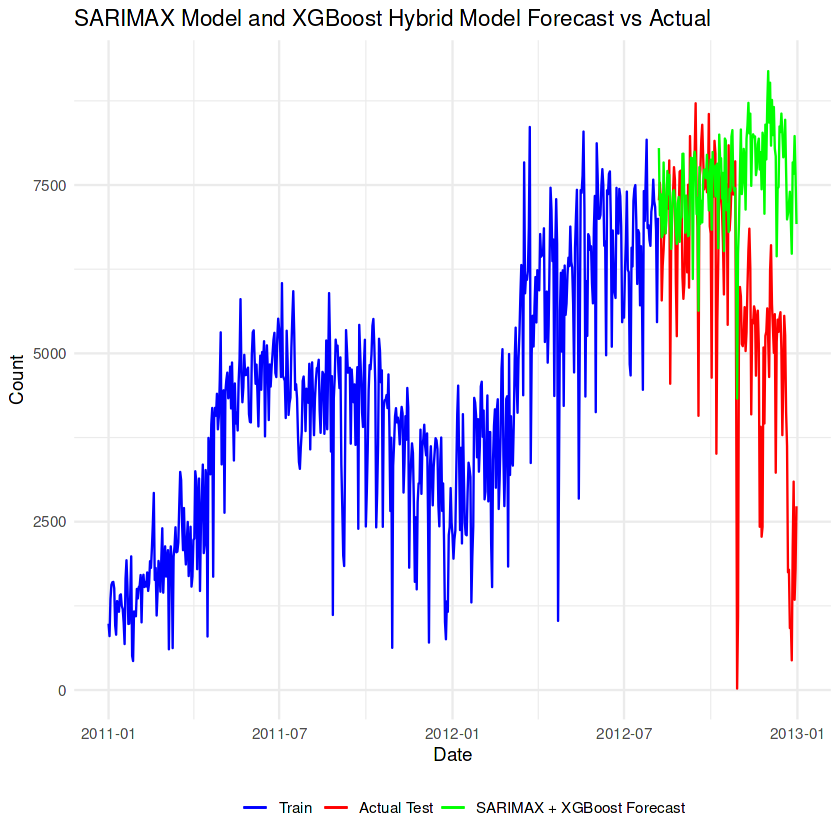

In [31]:
train_df <- data.frame(date = train_data$date, cnt = train_data$cnt, type = "Train")
test_df <- data.frame(date = test_data$date, cnt = test_data$cnt, type = "Test")
xgboost_forecast_df <- data.frame(date = test_data$date, cnt = xgboost_pred, type = "SARIMAX + XGBoost Forecast")

ggplot() +
  geom_line(data = train_df, aes(x = date, y = cnt, color = 'Train'), size = 0.5) +
  geom_line(data = test_df, aes(x = date, y = cnt, color = 'Actual Test'), size = 0.5) +
  geom_line(data = xgboost_forecast_df, aes(x = date, y = cnt, color = 'SARIMAX + XGBoost Forecast'), size = 0.5) +
  labs(title = 'SARIMAX Model and XGBoost Hybrid Model Forecast vs Actual',
       x = 'Date',
       y = 'Count') +
    scale_color_manual(values = c('Train' = 'blue', 'Actual Test' = 'red', 'SARIMAX + XGBoost Forecast' = 'green'),
                     breaks = c('Train', 'Actual Test', 'SARIMAX + XGBoost Forecast')) +  theme_minimal() +
  theme(legend.position = "bottom")+
  guides(color = guide_legend(title = NULL))



The green line representing the SARIMAX + XGBoost hybrid model's forecast closely follows the actual test data (red line), indicating that the hybrid model captures the fundamental patterns in the data well. Initially, the forecast aligns closely with the actual values, demonstrating the model's ability to track the data accurately. However, similar to the pure SARIMAX model, the hybrid model struggles to predict the subsequent downward trend accurately, leading to some deviations.

Overall, the plot shows that the SARIMAX + XGBoost hybrid model provides a reasonable forecast, closely aligning with the actual test data and improving the prediction accuracy compared to the SARIMAX model alone. This indicates that integrating XGBoost with SARIMAX enhances the model's ability to capture additional patterns in the data, resulting in more accurate and reliable forecasts. Nonetheless, the model's difficulty in anticipating the reverse trend suggests that there is still room for further refinement.